# Cross Validation and Lasso Regularization
Using the dataset of house prices a model that predicts house prices given the other features in the dataset.   
- Multiple linear regression model.    
- k-fold cross validation to find an appropriate value for the L1 regularisation parameter $\lambda$.    
- L1 regularisation (lasso) to find features that may not be needed for the prediction.


- **Data**: house sales dataset
- **Model**: a linear model
- **Cost** (aka Loss): RMSE and regularization penalty


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn

%matplotlib inline
plt.rcParams["figure.figsize"] = (7,5)

# The data
We use the house sales dataset from kaggle.com.   
This dataset contains house sale prices for King County. It includes houses sold between May 2014 and May 2015.   
https://www.kaggle.com/divan0/multiple-linear-regression/data

First, we read the data from a csv file into a Pandas dataframe.   
Familiarise yourself with the dataset. Here are some functions you can use to get an overview.

| Function | Description |
| --- | --- |
| [`df.head(n)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) | Returns the first `n` rows of the DataFrame df. Default value of `n` is 5. |
| [`df.tail(n)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) | Returns the last `n` rows of the DataFrame df. Default value of `n` is 5. |
| [`df.describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) | Provides a summary of the central tendency, dispersion and shape of the dataset’s distribution. |
| [`df.info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) | Returns essential details about your dataset. |
| [`df.columns`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) | Returns the names of all columns in the DataFrame. |
| [`df.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html) | Returns a tuple representing the dimensionality of the DataFrame (rows, columns). |



In [7]:
dataset = pd.read_csv('kc_house_data.csv')
dataset = dataset.iloc[:650, :] # we only use part of the dataset

In [8]:
# Info function gives us the number of rows and columns, and the data type of each column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             650 non-null    int64  
 1   date           650 non-null    object 
 2   price          650 non-null    float64
 3   bedrooms       650 non-null    int64  
 4   bathrooms      650 non-null    float64
 5   sqft_living    650 non-null    int64  
 6   sqft_lot       650 non-null    int64  
 7   floors         650 non-null    float64
 8   waterfront     650 non-null    int64  
 9   view           650 non-null    int64  
 10  condition      650 non-null    int64  
 11  grade          650 non-null    int64  
 12  sqft_above     650 non-null    int64  
 13  sqft_basement  650 non-null    int64  
 14  yr_built       650 non-null    int64  
 15  yr_renovated   650 non-null    int64  
 16  zipcode        650 non-null    int64  
 17  lat            650 non-null    float64
 18  long      

In [9]:
# head shows the first 5 rows.
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
# We can use the describe function to get a summary of the data.
dataset.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,6.500000e+02,6.500000e+02,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000
mean,4.519518e+09,5.259248e+05,3.338462,2.074615,2092.013846,15689.206154,1.454615,0.010769,0.230769,3.455385,7.647692,1783.655385,308.358462,1969.092308,92.110769,98074.476923,47.548078,-122.207748,2006.261538,14379.912308
std,2.914878e+09,3.499419e+05,0.854192,0.734895,934.593114,30893.962647,0.509405,0.103294,0.764570,0.688007,1.189529,828.056671,458.561944,28.263902,419.078702,52.827599,0.141877,0.141181,688.415516,26792.288555
min,1.150089e+07,8.000000e+04,1.000000,0.750000,430.000000,649.000000,1.000000,0.000000,0.000000,1.000000,4.000000,430.000000,0.000000,1900.000000,0.000000,98001.000000,47.177500,-122.490000,830.000000,660.000000
25%,1.912467e+09,3.050000e+05,3.000000,1.750000,1412.500000,5578.750000,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98032.000000,47.437050,-122.326750,1510.000000,5466.500000
50%,3.851306e+09,4.380000e+05,3.000000,2.250000,1930.000000,8159.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1585.000000,0.000000,1973.500000,0.000000,98058.000000,47.563500,-122.218500,1860.000000,8050.000000
75%,7.335050e+09,6.396750e+05,4.000000,2.500000,2500.000000,11582.750000,2.000000,0.000000,0.000000,4.000000,8.000000,2190.000000,580.000000,1992.000000,0.000000,98116.000000,47.673400,-122.117250,2390.000000,10639.500000
max,9.828703e+09,3.075000e+06,7.000000,5.000000,6070.000000,315374.000000,3.000000,1.000000,4.000000,5.000000,12.000000,6070.000000,2060.000000,2015.000000,2014.000000,98199.000000,47.777600,-121.709000,4760.000000,233971.000000


We want to use the column *price* as a dependant/target variable and the remaining columns as independent/predictor variables.  
Since we don't want to use *id* and *date* for our prediction, we drop them from our predictor variables as well.

In [11]:
from sklearn.model_selection import train_test_split

target_column = 'price'

X_Data = dataset.drop(['id', 'date', target_column], axis='columns')
y_Data = pd.DataFrame(dataset[target_column])

X_train, X_test, Y_train, Y_test = train_test_split(X_Data, y_Data, test_size=0.2, random_state=1)

feature_names = X_train.columns

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')
print(f'Feature names: {feature_names}')


Shape of X_train: (520, 18)
Shape of Y_train: (520, 1)
Shape of X_test: (130, 18)
Shape of Y_test: (130, 1)
Feature names: Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## Preprocessing
Use the **StandardScaler** on our feature columns to give them a mean of zero and a standard deviation of 1.   
In practice, it may be useful to preprocess or scale the values of the target variable as well.   


In [12]:
from sklearn.preprocessing import StandardScaler

x_standard_scaler = StandardScaler()

# The Model
We use a Multiple Linear Regression model with L1-regularization (Lasso)  


**combine the data preprocessing and the model in one pipeline**. (see next cell)     
 This way we don't need to manually scale the input data first.


In [13]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline 
from sklearn import metrics

l1_param = 5000 # regularization parameter

model = linear_model.Lasso(alpha=l1_param, max_iter=5000)

model_pipe  = Pipeline([
    ('scaler', x_standard_scaler),
    ('model', model)
])



In [14]:
# To track the error, this time we don't use the Mean Squared Error, because the values become very large.
# Instead we use the Root Mean Squared Error (rmse)
# https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

# fitting the model onto the data
model_pipe.fit(X_train, Y_train)

# evaluation of the train Root Mean Squared Error from our predictions
Y_hat = model_pipe.predict(X_train)
error = rmse(Y_train, Y_hat)
print(f'Root Mean Squared Error: {error}')

# sklearn features a score method for most predictors. It predicts the target variables and calculates a r-squared score.
# r-squared shows how well the data fit the regression model. r-squared of 1.0 is the best score we can get.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso.score
r2 = model_pipe.score(X_train, Y_train)
print(f'r-squared score: {r2}')

Root Mean Squared Error: 189551.96004833287
r-squared score: 0.7247976101257333



L1-regularization will usualy lead to certain weights becoming zero, given the regularization parameter is high enought.   
We can access the weights of the model in the pipeline.

In [15]:

# we see that with the L1 parameter we chose above, some of the models coefficients are zero.
# This means that the model has removed some of the features from the model.
model_coefficients = model_pipe['model'].coef_

print(model_coefficients)


[     0.              0.          87617.38830414      0.
     -0.          49564.14010586  66978.15048815   3222.72462762
 109479.14662643   8361.24835944      0.         -40571.52729548
  32104.33295203  -5714.56011237  78872.63470125   -909.06464498
  47475.90387275      0.        ]


# Cross-validation
Evaluate the model performance using cross-validation.     
- Use 5-fold cross validation to estimate mean and variance of the out-of-sample error.  
- You are free to use a Python library (sklearn) to create the splits or to implement it yourself.  
- Re-run your notebook for different values of k.  

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [16]:
# example implementation of k-fold as generator function
# https://www.tutorialsteacher.com/python/python-generator
def split_k_fold(X, k=5):
    # splitting the data into test and training set
    # it is important, that the data is shuffled before the splitting
    n_samples = X.shape[0]
    fold_size = int(n_samples / k)
    rng = np.random.default_rng(seed=5)
    idx = rng.permutation(n_samples)
    for n in range(k):
        train_idx = np.concatenate(
            [idx[:n * fold_size], idx[n * fold_size + fold_size:-1]])
        test_idx = idx[n * fold_size:n * fold_size + fold_size]
        yield train_idx, test_idx

# in practice you should use the scikit-learn (or other library) implementation unless you want to implement your own innovative scheme

###

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.model_selection import KFold

nr_of_splits = 5

kf = KFold(n_splits=nr_of_splits, shuffle=True, random_state=1) # it is important to shuffle data! 
print(kf)

# initialize an empty python list to store the out-of-sample Root Mean Squared Error for each fold
val_errors_list = []

for train_idx, val_idx in kf.split(X_train):
    # note: it is very important to scale each training set separately. 
    # scaling only once, on ALL data, is a typical bug because then, information from the validation-data leaks into the 
    # training pipeline. The training data is no longer "unseen".
    # Here the scaling is done directly in the pipeline

    model_pipe.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])

    # calculate the out-of-sample Root Mean Squared Error and store it in the list
    X_val = X_train.iloc[val_idx]
    Y_val = Y_train.iloc[val_idx]

    Y_hat_val = model_pipe.predict(X_val)
    Y_val = Y_train.iloc[val_idx]
    error = rmse(Y_val, Y_hat_val)
    
    val_errors_list.append(error)


val_errors_list = np.array(val_errors_list)
val_error_mean = np.mean(val_errors_list)
val_error_std = np.std(val_errors_list)
print(val_errors_list)
print(f'out-of-sample Root Mean Squred Error using {nr_of_splits}-fold CV:\nmean: {val_error_mean}\nstandard-deviation: {val_error_std}')

###



KFold(n_splits=5, random_state=1, shuffle=True)
[216303.05274692 226632.77628758 212002.42303768 179696.5120585
 201547.16157087]
out-of-sample Root Mean Squred Error using 5-fold CV:
mean: 207236.38514031112
standard-deviation: 15949.617189458238


In [19]:

# sklearn offers a cross_val_score function that evaluates the cross validation scores in one call
from sklearn.model_selection import cross_val_score

nr_of_splits = 5

val_errors_list = cross_val_score(model_pipe, X_train, Y_train, cv=nr_of_splits, scoring='neg_root_mean_squared_error')

val_error_mean = -np.mean(val_errors_list)
val_error_std = np.std(val_errors_list)

print(val_errors_list)

print(f'Out-of-sample Root Mean Squared Error using {nr_of_splits}-fold CV:')
print(f'mean: {val_error_mean}\nstandard-deviation: {val_error_std}')
###

[-148003.71396819 -215491.34864647 -235816.24460854 -161981.6120581
 -231457.07241308]
Out-of-sample Root Mean Squared Error using 5-fold CV:
mean: 198549.99833887655
standard-deviation: 36471.445609583396


### Comments on Cross-validation (CV)
We observe a high variance in the validation errors of the different folds. A single test-set would not give us an estimate of this variance. This highlights the importance of the CV: we obtain a much more reliable estimate of the generalization performance of our model.


# k-fold for selection of hyper parameters

k-Fold implementation from above to find a 'optimal' value for the regularization parameter $\lambda$  
For every $\lambda$ you try, calculate and store the mean and std of the out-of-sample root mean squared rrror. For every $\lambda$, you need to reinitialize the model and the pipeline. 

Hint: as the values of the target variable (price) are high (as it represents house prices in dollars), we also need a large regularization parameter. Try regularization parameters in the range of about 100 - 25000.



In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.model_selection import KFold

nr_of_splits = 5

kf = KFold(n_splits=nr_of_splits, shuffle=True, random_state=1) # it is important to shuffle data! otherwise we train and test on different segments

# initialize an empty python list. it's ok (and simple) to use a growing list.
scores_history = {'val_score_mean': [],
               'val_score_std': [],
               'train_score_mean': [],
               'train_score_std': [],
               'l1_lambda': []}

l1_parameters = np.linspace(100, 25_000, 500) # the values for lambda we want to try

for l1_param in l1_parameters:

    # first the model need to be re-initialized with the new regularization parameter.
    model = linear_model.Lasso(alpha=l1_param, max_iter=5000)
    model_pipe  = Pipeline([
        ('scaler', x_standard_scaler),
        ('model', model)
    ])

    val_errors_list = []
    train_errors_list = []
    
    for train_idx, val_idx in kf.split(X_train):

        # fit the model on the training data
        model_pipe.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])

        # calculate the out-of-sample/test Root Mean Squared Error and store it in the list
        X_val = X_train.iloc[val_idx]
        Y_val = Y_train.iloc[val_idx]

        Y_hat_val = model_pipe.predict(X_val)

        Y_val = Y_train.iloc[val_idx]
        error = rmse(Y_val, Y_hat_val)
        val_errors_list.append(error)
    
    
        X_train_folds = X_train.iloc[train_idx]
        Y_train_folds = Y_train.iloc[train_idx]
        Y_hat_train = model_pipe.predict(X_train_folds)

        error = rmse(Y_train_folds, Y_hat_train)
        train_errors_list.append(error)

    val_errors_list = np.array(val_errors_list)
    val_scores_mean = np.mean(val_errors_list)
    val_scores_std = np.std(val_errors_list)
    
    train_errors_list = np.array(train_errors_list)
    train_scores_mean = np.mean(train_errors_list)
    train_scores_std = np.std(train_errors_list)

    scores_history['val_score_mean'].append(val_scores_mean)
    scores_history['val_score_std'].append(val_scores_std)
    
    scores_history['train_score_mean'].append(train_scores_mean)
    scores_history['train_score_std'].append(train_scores_std)
    
    scores_history['l1_lambda'].append(l1_param)

error_means = np.array(scores_history['val_score_mean'])
error_stds = np.array(scores_history['val_score_std'])
error_means_train = np.array(scores_history['train_score_mean'])
error_stds_train = np.array(scores_history['train_score_std'])

# the best lambda is the one that minimizes the validation mse
l1_lambda_opt = scores_history['l1_lambda'][np.argmin(error_means)]
print(f'Best lambda: {l1_lambda_opt}')

Best lambda: 10678.75751503006


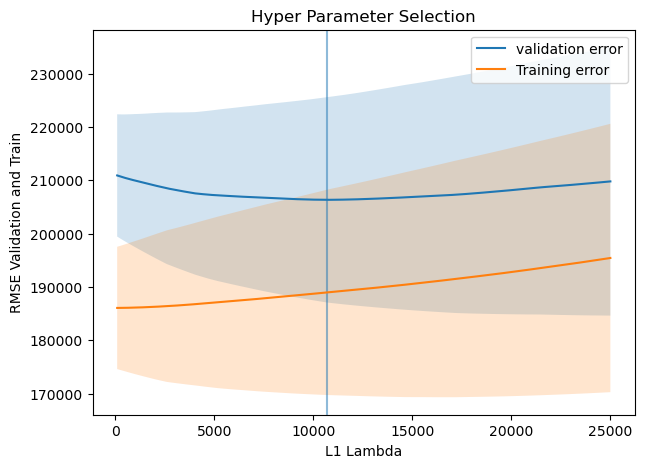

In [21]:
# plotting the result
plt.figure()
plt.plot(scores_history['l1_lambda'], error_means, label='validation error')
plt.fill_between(scores_history['l1_lambda'],
                 error_means - error_stds,
                 error_means + error_stds,
                 alpha=0.2)
plt.title('Hyper Parameter Selection')
plt.ylabel('RMSE Validation and Train')
plt.xlabel('L1 Lambda')
plt.axvline(l1_lambda_opt, alpha=0.5)

plt.plot(scores_history['l1_lambda'], error_means_train, label='Training error')
plt.fill_between(scores_history['l1_lambda'],
                 error_means_train - error_stds,
                 error_means_train + error_stds,
                 alpha=0.2)
plt.legend()

In [22]:
# sklearn offers a grid search function for hyperparameter tuning
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

nr_of_splits = 5

model = linear_model.Lasso(max_iter=5000)
model_pipe  = Pipeline([
    ('scaler', x_standard_scaler),
    ('model', model)
])

parameters = [
    {'model__alpha': np.linspace(100, 25_000, 500)}
]

clf = GridSearchCV(model_pipe, parameters, cv=nr_of_splits)
clf.fit(X_train, Y_train)

print(f'Best Parameter: {clf.best_params_}')

# we can access the coefficients of the best model
clf.best_estimator_['model'].coef_

###

Best Parameter: {'model__alpha': 10978.15631262525}


array([     0.        ,      0.        ,  94891.64098101,      0.        ,
           -0.        ,  44839.32907081,  64882.60338758,      0.        ,
       104151.39763476,      0.        ,      0.        , -32326.85754517,
        28160.98053982,     -0.        ,  73437.6272188 ,     -0.        ,
        46651.16714464,      0.        ])

### Evaluating the final model
We can use the test set we created earlier to evaluate the final model.  
We need to re-train the model on the entire training set.

In [23]:

best_lambda = l1_lambda_opt # We use the lambda that was found in the Example Solution 1

model = linear_model.Lasso(alpha=best_lambda, max_iter=5000)
model_pipe  = Pipeline([
    ('scaler', x_standard_scaler),
    ('model', model)
])
model_pipe.fit(X_train, Y_train)

# calculate the out-of-sample/test Root Mean Squared Error
Y_hat_test = model_pipe.predict(X_test)
error = np.sqrt(metrics.mean_squared_error(Y_test, Y_hat_test))
print(f'Test Root Mean Squared Error: {error}')


Test Root Mean Squared Error: 167803.00671129726


# Feature selection
We saw that the L1-normalization resulted in certain model coefficients becoming zero.
- Fit a Model with the found value for alpha from before
- Access the models coefficients and print them with their corresponding feature name from the dataset
- Prepare the data again so that X_train only contains the features that are non zero


In [24]:
model = linear_model.Lasso(alpha=l1_lambda_opt, max_iter=5000)
model_pipe  = Pipeline([
    ('scaler', x_standard_scaler),
    ('model', model)
])

model_pipe.fit(X_train, Y_train)

model_coefficients = model_pipe['model'].coef_

# We can print the corresponding feature name to see what coefficients got set to zero
for coef, name in zip(model_coefficients, feature_names):
    print(f'{name:>20} - {coef:.5f}')


model_pipe['model'].intercept_
###


            bedrooms - 0.00000
           bathrooms - 0.00000
         sqft_living - 94865.02016
            sqft_lot - 0.00000
              floors - -0.00000
          waterfront - 45068.12232
                view - 64928.91488
           condition - 0.00000
               grade - 104450.81319
          sqft_above - 0.00000
       sqft_basement - 0.00000
            yr_built - -32718.90625
        yr_renovated - 28304.89115
             zipcode - -0.00000
                 lat - 73599.34234
                long - -0.00000
       sqft_living15 - 46809.09483
          sqft_lot15 - 0.00000


array([530532.43076923])

In [25]:
# We can create a mask of all non-zero values and use numpy indexing so select these found features
# Alternatively we can create a list with the selected feature names manually

selected_features = feature_names[model_coefficients.nonzero()]
print(selected_features)


# Data perparation
target_column = 'price'
X_Data = pd.DataFrame(dataset[selected_features])
Y_Data = pd.DataFrame(dataset[target_column])

X_train, X_test, Y_train, Y_test = train_test_split(X_Data, Y_Data, test_size=0.2, random_state=1)

print(X_train.shape)
print(Y_train.shape)

### 

Index(['sqft_living', 'waterfront', 'view', 'grade', 'yr_built',
       'yr_renovated', 'lat', 'sqft_living15'],
      dtype='object')
(520, 8)
(520, 1)


### Evaluating the final model
We can now evaluate the performance of a unregularized linear regression model on this reduced dataset.

We see that in this specific case, the model performs as well as the regularized model on the original dataset.

In [26]:

model = linear_model.LinearRegression() 
model_pipe  = Pipeline([
    ('scaler', x_standard_scaler),
    ('model', model)
])
model_pipe.fit(X_train, Y_train)

# calculate the out-of-sample/test Root Mean Squared Error
Y_hat_test = model_pipe.predict(X_test)
error = np.sqrt(metrics.mean_squared_error(Y_test, Y_hat_test))
print(f'Test Root Mean Squared Error: {error}')


Test Root Mean Squared Error: 163803.24829674914
